# Graph AutoEncoder with StellarGraph

In [1]:
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding


from tensorflow import keras
from stellargraph import datasets

2024-04-14 21:23:05.152203: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-14 21:23:05.152254: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-14 21:23:08.064209: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-14 21:23:08.064257: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-14 21:23:08.064280: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-23-216): /proc/driver/nvidia/version does not exist
2024-04-14 21:23:08.064620: I tensorflow/core/platform/cpu_f

In [2]:
dataset = datasets.Cora()
G, _ = dataset.load()

In [3]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [4]:
edge_splitter_test = EdgeSplitter(G)

G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

edge_splitter_train = EdgeSplitter(G_test)

G_train, edge_ids_train, edge_labels_train = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 542 positive and 542 negative edges. **
** Sampled 542 positive and 542 negative edges. **


In [5]:
train_gen = FullBatchLinkGenerator(G, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

Using GCN (local pooling) filters...


In [6]:
test_gen = FullBatchLinkGenerator(G, method="gcn")
test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

Using GCN (local pooling) filters...


In [7]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3
)

In [8]:
x_inp, x_out = gcn.in_out_tensors()

In [9]:
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

In [10]:
prediction = keras.layers.Reshape((-1,))(prediction)


In [11]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01),
    loss=keras.losses.binary_crossentropy,
    metrics=["binary_accuracy"],
)

/home/ubuntu/.pyenv/versions/py3.8/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(1, 2708, 1433)]    0           []                               
                                                                                                  
 input_3 (InputLayer)           [(1, None, 2)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(1, None)]          0           []                               
                                                                                                  
 dropout (Dropout)              (1, 2708, 1433)      0           ['input_1[0][0]']                
                                                                                              

In [13]:
history = model.fit(train_flow, validation_data=test_flow, epochs=50)

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 1.5763 - binary_accuracy: 0.5000 - val_loss: 1.9396 - val_binary_accuracy: 0.5609
Epoch 2/50
1/1 [==============================] - 0s 186ms/step - loss: 2.1878 - binary_accuracy: 0.5812 - val_loss: 0.6680 - val_binary_accuracy: 0.7149
Epoch 3/50
1/1 [==============================] - 0s 194ms/step - loss: 0.6135 - binary_accuracy: 0.7066 - val_loss: 0.6407 - val_binary_accuracy: 0.6624
Epoch 4/50
1/1 [==============================] - 0s 188ms/step - loss: 0.6331 - binary_accuracy: 0.6577 - val_loss: 0.6610 - val_binary_accuracy: 0.7011
Epoch 5/50
1/1 [==============================] - 0s 180ms/step - loss: 0.6754 - binary_accuracy: 0.6827 - val_loss: 0.6487 - val_binary_accuracy: 0.7094
Epoch 6/50
1/1 [==============================] - 0s 184ms/step - loss: 0.6670 - binary_accuracy: 0.7085 - val_loss: 0.6178 - val_binary_accuracy: 0.6780
Epoch 7/50
1/1 [==============================] - 0s 184ms/step - loss: 0.5983 

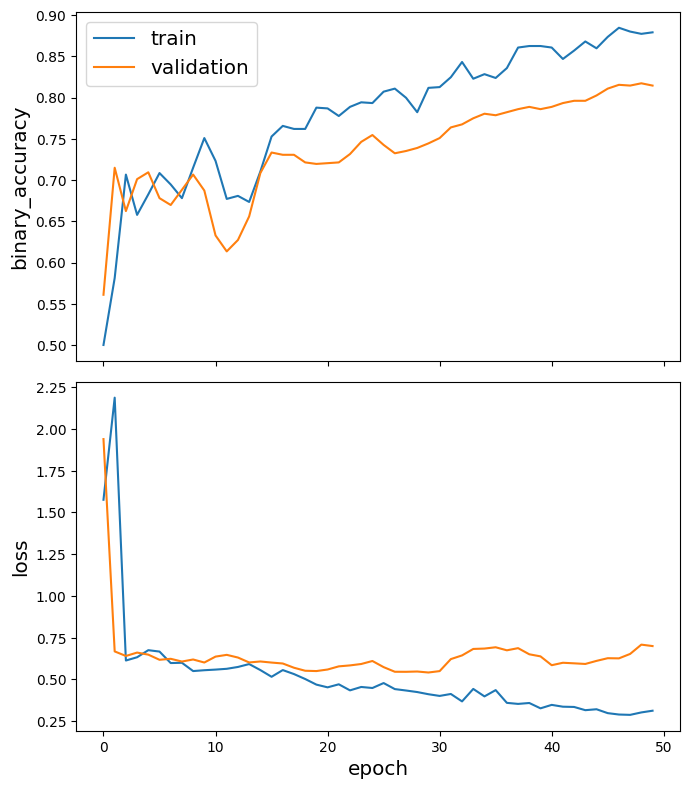

In [14]:
from stellargraph.utils import plot_history

plot_history(history)